In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import numpy as np
import xml.etree.ElementTree as ET
import gzip
import random
import subprocess
import sys
import os
import networkx as nx
from pathlib import Path
import math
import json
import numpy as np

os.environ["LD_LIBRARY_PATH"] = os.path.expanduser("~/Libs/libnsl")
os.environ["SUMO_HOME" ] = os.path.expanduser("~/Envs/sumo-env/lib/python3.10/site-packages/sumo")

sys.path.append('/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/src')
from rawDataProcessing import autoFillMissingInfo, buildDetailedData

In [42]:
MAPPING_JSON = "/home/hoai-linh.dao/Works/EVCS/CEREMA-Mini/data/processed-data/AMP-mapping.json"

DIR = Path("/home/hoai-linh.dao/Works/EVCS/EV-Simulations/data/processed-data/regional-traffic-flow/AMP")
NAME = DIR.name
RAW_CSV = DIR / f"raw-{NAME}.csv"
INTERPOLATED_CSV = DIR / f"interpolated-{NAME}.csv"
MAPPED_INTERPOLATED_CSV = DIR / f"mapped-interpolated-{NAME}.csv"
DETAILED_PER_SEC_CSV = DIR / f"detailed-{NAME}.csv"
DATA_JSON = DIR / f"{NAME}-from-doc.json"
OD_MATRICES_DIR = DIR / "od_matrices" 
START_HOUR = 3

# MAIN

In [53]:
df = pd.read_csv(RAW_CSV)

df['seconds'] = df['Heures'] * 3600
df = df.sort_values('seconds')

seconds = np.arange(0, 86400+1)

indices = np.searchsorted(df['seconds'].values, seconds, side='right') - 1
step_values = df['Nombre de départs'].values[np.clip(indices, 0, len(df)-1)]

linear_values = np.interp(seconds, df['seconds'], df['Nombre de départs'])

rate_per_sec = step_values / 3600

full = pd.DataFrame({
    'seconds': seconds,
    'step_count': step_values,
    'linear_count': linear_values,
    'rate_per_second': rate_per_sec
})

full.to_csv(DETAILED_PER_SEC_CSV, index=False)

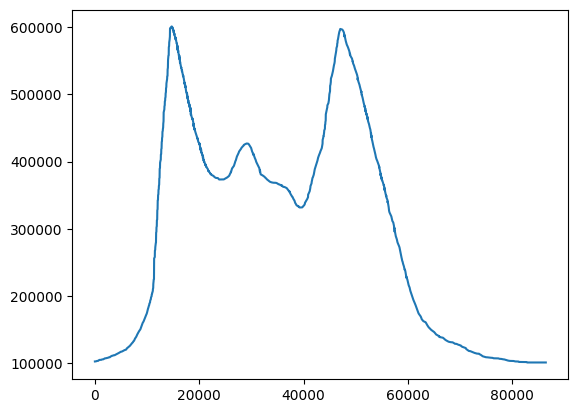

In [56]:
df2 = pd.read_csv(DETAILED_PER_SEC_CSV)
plt.plot(df2['seconds'], df2['linear_count'])


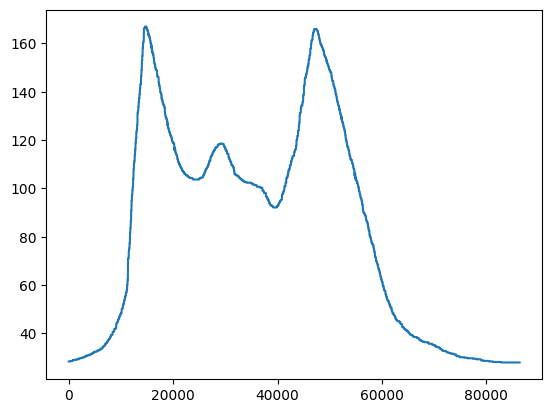

In [58]:
plt.plot(df2['seconds'], df2['rate_per_second'])


In [5]:
df1 = pd.read_csv(RAW_CSV)
df1.columns = ["Heures", "Nombre de départs"]
df1["Nombre de départs"] = df1["Nombre de départs"].clip(lower=0)
df1.to_csv(RAW_CSV, index=False)

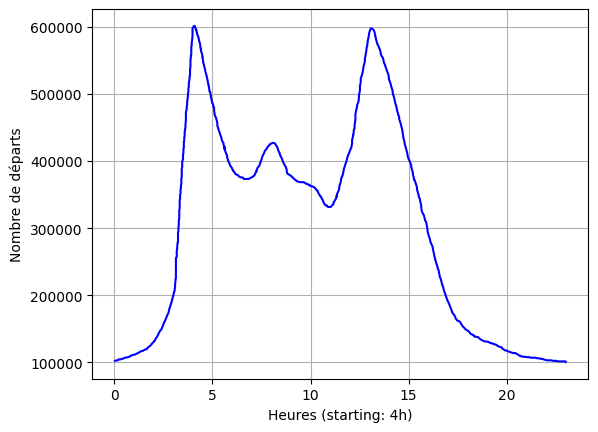

In [44]:
plt.plot(df1["Heures"], df1["Nombre de départs"], linestyle='-', color='b', alpha=1.0)
plt.xlabel("Heures (starting: 4h)")
plt.ylabel("Nombre de départs")
plt.grid(True)
plt.show()

KeyError: 'linear_count'

In [48]:
import pandas as pd
import numpy as np

# 1) Đọc dữ liệu gốc
df = pd.read_csv(RAW_CSV)  # cột Heures, Nombre de départs (cumulative)

# 2) Sort & ép monotonic
df = df.sort_values('Heures').reset_index(drop=True)
df['Nombre de départs'] = df['Nombre de départs'].cummax()

# 3) Trừ baseline = giá trị cumulative đầu tiên
baseline_cum = df['Nombre de départs'].iloc[0]
df['Nombre de départs'] = df['Nombre de départs'] - baseline_cum

# 4) Drop duplicate timestamps
df = df.drop_duplicates(subset='Heures', keep='first')

# 5) Tính delta_trips & delta_hours
df['delta_trips'] = df['Nombre de départs'].diff().fillna(df['Nombre de départs'])
df['delta_hours'] = df['Heures'].diff().fillna(df['Heures'])
df = df[df['delta_hours'] > 0]  # chắc chắn delta_hours >0

# 6) Tính rate_per_hr (xe/giờ)
df['rate_per_hr'] = df['delta_trips'] / df['delta_hours']

# 7) Rải xuống giây
seconds = pd.DataFrame({'sec_since_4am': range(24*3600)})
df_sec  = pd.DataFrame({
    'sec_since_4am': (df['Heures']*3600).round().astype(int),
    'rate_per_hr':   df['rate_per_hr']
})
full = seconds.merge(df_sec, on='sec_since_4am', how='left')
full['rate_per_hr'] = full['rate_per_hr'].interpolate().bfill().ffill()

# 8) Chuyển rate→count mỗi giây, scale và round
scale = 0.52
full['count'] = ((full['rate_per_hr']/3600) * scale).round().astype(int)

# 9) Xuất file
full[['sec_since_4am','count']].to_csv('detailed-per-sec.csv', index=False)

# 10) Xác nhận tổng khớp
print("Tổng trips:", full['count'].sum())


Tổng trips: 7151574


In [46]:
df3 = pd.read_csv(DETAILED_PER_SEC_CSV) 

print(df3['count'].sum())
# df3['hour'] = (df3['sec_since_4am'] / 3600 + 4) % 24

# df3['smoothed'] = df3['count'].rolling(window=3600, min_periods=1, center=True).mean()

# plt.figure()
# plt.plot(df3['hour'], df3['smoothed'])
# plt.xlabel('Heures de départ')
# plt.ylabel('Départs par seconde (moyenne glissante 1h)')
# plt.title('Distribution des départs sur 24h')
# plt.xlim(0, 24)
# plt.xticks(range(0,25,2), [f"{h}h" for h in range(0,25,2)])
# plt.tight_layout()
# plt.show()

6025187
